In [499]:
import pandas as pd
import seaborn as sns
import numpy as np

Events_Sequence = pd.read_csv('Events_Sequence.txt', sep = '\t')
aircraft = pd.read_csv('aircraft.txt')
occurrences = pd.read_csv('Occurrences.txt', sep = ',')
seq_of_events = pd.read_csv('seq_of_events.txt', sep = '\t')
eventCodes = pd.read_csv('ct_seqevt.txt')

ev_ID = sum(aircraft.values.tolist(), [])

In [500]:
len(ev_ID)

2243

In [501]:
Events_Sequence.head(2)

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Occurrence_Description,phase_no,eventsoe_no,Defining_ev,lchg_date,lchg_userid
0,20001208X08803,1,3,400240,Enroute - Loss of control in flight,400,240,1,5/13/2019 14:50:49,bowl
1,20001212X19469,1,1,550900,Landing - Miscellaneous/other,550,900,1,6/25/2015 14:54:25,sedj


In [502]:
new = Events_Sequence["Occurrence_Description"].str.split("-", n = 1, expand = True)

Events_Sequence.insert(5, 'Phase', 'Unknown')
Events_Sequence.insert(6, 'Description', 'Unknown')
Events_Sequence['Phase'] = new[0].str.strip()
Events_Sequence['Description'] = new[1].str.strip()

In [503]:
Events_Sequence.head()

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Occurrence_Description,Phase,Description,phase_no,eventsoe_no,Defining_ev,lchg_date,lchg_userid
0,20001208X08803,1,3,400240,Enroute - Loss of control in flight,Enroute,Loss of control in flight,400,240,1,5/13/2019 14:50:49,bowl
1,20001212X19469,1,1,550900,Landing - Miscellaneous/other,Landing,Miscellaneous/other,550,900,1,6/25/2015 14:54:25,sedj
2,20010304X00536,1,1,400350,Enroute - Security/criminal event,Enroute,Security/criminal event,400,350,1,6/25/2015 15:51:08,sedj
3,20010304X00536,2,1,400350,Enroute - Security/criminal event,Enroute,Security/criminal event,400,350,1,6/25/2015 15:51:23,sedj
4,20080109X00036,1,1,551230,Landing-flare/touchdown - Loss of control on g...,Landing,flare/touchdown - Loss of control on ground,551,230,1,11/16/2017 13:41:08,broda


In [504]:
second_phases = ['cruise', 'flare/touchdown', 'aerobatics', 'climb to cruise', 'landing roll', 'IFR initial approach', 
                 'IFR final approach', 'IFR missed approach', 'low-alt flying', 'VFR go-around', 'descent', 
                 'VFR pattern final', 'rejected takeoff', 'circling (IFR)']
def f(x):
    if '-' in x:
        if x.split('-')[0].strip() in second_phases:
            return x.split('-', 1)[1].strip()
    else:
        return x

Events_Sequence['Description'] = Events_Sequence['Description'].map(f)

#### Accident proportion by phases

In [505]:
df_events_sequences = Events_Sequence[Events_Sequence['ev_id'].isin(ev_ID)]

df_events_sequences.reset_index(inplace=True)
del df_events_sequences['index']

In [506]:
df_events_sequences.head()

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Occurrence_Description,Phase,Description,phase_no,eventsoe_no,Defining_ev,lchg_date,lchg_userid
0,20080118X00073,1,1,200200,Pushback/towing - Ground collision,Pushback/towing,Ground collision,200,200,1,2/2/2009 13:27:45,mcgk-c
1,20080118X00073,2,1,200200,Pushback/towing - Ground collision,Pushback/towing,Ground collision,200,200,1,2/2/2009 13:28:51,mcgk-c
2,20080222X00229,1,1,401900,Enroute-climb to cruise - Miscellaneous/other,Enroute,Miscellaneous/other,401,900,1,12/23/2008 15:40:20,stam
3,20080222X00229,1,2,402900,Enroute-cruise - Miscellaneous/other,Enroute,Miscellaneous/other,402,900,0,12/23/2008 15:40:20,stam
4,20080305X00267,1,1,404360,Enroute-descent - Turbulence encounter,Enroute,Turbulence encounter,404,360,1,7/28/2009 14:59:12,grol


In [507]:
import collections

counter = collections.Counter(df_events_sequences['Phase'])
counter

Counter({'Pushback/towing': 20,
         'Enroute': 170,
         'Taxi': 48,
         'Standing': 41,
         'Takeoff': 34,
         'Landing': 91,
         'Prior to flight': 25,
         'Initial climb': 37,
         'Approach': 46,
         'Pushback/tow': 14,
         'Post': 6,
         'Other': 9,
         'Unknown': 4,
         'Emergency descent': 2,
         'Uncontrolled descent': 1,
         'After landing': 4})

Text(0, 0.5, 'Proportion')

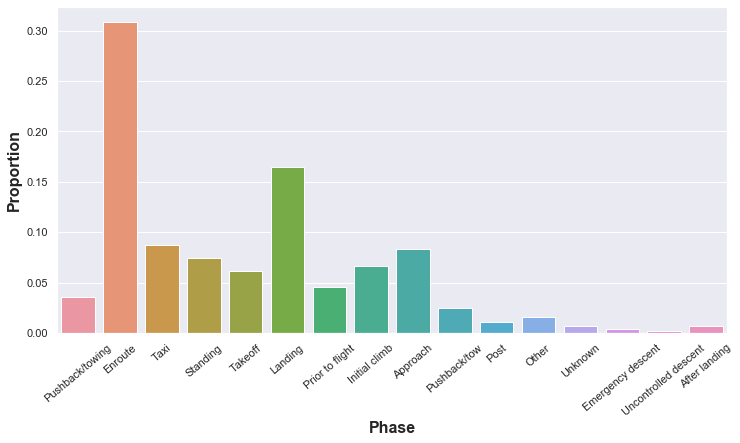

In [508]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

proportion = np.array(list(counter.values()))/sum(list(counter.values()))

plt.figure(figsize = (12, 6))
sns.barplot(x = list(counter.keys()), y = proportion)
sns.set(font_scale=1)
plt.xticks(rotation=40)
plt.xlabel('Phase', fontsize = 16, fontweight = 'bold')
plt.ylabel('Proportion', fontsize = 16, fontweight = 'bold')

#### Create raw transition graph from the Table Events_Sequence

In [509]:
nodeDesp = list(df_events_sequences['Description'].unique())

In [510]:
def findDespByID(ID):
    desp = df_events_sequences.loc[df_events_sequences['ev_id'] == ID]
    return list(desp['Description'])

dictEdges = {}

for ID in df_events_sequences['ev_id']:
    desp = findDespByID(ID)
    
    if len(desp) == 1:
        nodeFrom = nodeDesp.index(desp[0])
        nodeTo = nodeDesp.index(desp[0])
        
        key = str(nodeFrom)
        
        if key in dictEdges.keys():
            dictEdges[key] = dictEdges[key] + 1  
        else:
            dictEdges[key] = 1    
    else:
        for i in range(len(desp) - 1):
            nodeFrom = nodeDesp.index(desp[i])
            nodeTo = nodeDesp.index(desp[i+1])

            key = str(nodeFrom) + '->' + str(nodeTo)
            
            if key in dictEdges.keys():
                dictEdges[key] = dictEdges[key] + 1
            else:
                dictEdges[key] = 1

In [511]:
import operator

sorted_x = sorted(dictEdges.items(), key=operator.itemgetter(1))

In [512]:
import pygraphviz as pgv
from IPython.display import Image

def drawImage(dot):
    return Image(pgv.AGraph(dot).draw(format='jpg', prog='dot'))

def drawPDF(dot, fileName):
    return pgv.AGraph(dot).draw(fileName + '.pdf', prog='dot')

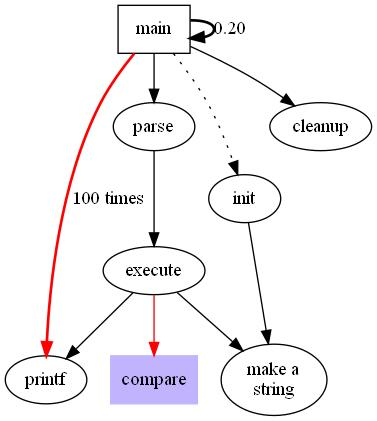

In [513]:
g1 = """digraph top {
    size ="12,12";
    main [shape=box]; /* this is a comment */
    main -> parse [weight=80];
    main -> main [style=bold, label="0.20"];
    parse -> execute;
    main -> init [style=dotted];
    main -> cleanup;
    execute -> { make_string; printf}
    init -> make_string;
    edge [color=red]; // so is this
    main -> printf [style=bold,label="100 times"];
    make_string [label="make a\nstring"];
    node [shape=box,style=filled,color=".7 .3 1.0"];
    execute -> compare;
}"""


drawImage(g1)

In [514]:
def create_graph():
    g = """digraph top {
    size ="12,12";"""
    
    for key, value in dictEdges.items():
        
        if '->' in key:
            nodeFrom = key.split('->')[0]
            nodeTo = key.split('->')[1]
            g += str(nodeFrom) + '->' + str(nodeTo) + '[style=bold, label=' + str(value) + ']'
  
    g += '}'
    
    return g

In [515]:
nodeDesp[21]

'Fire/smoke (non-impact)'

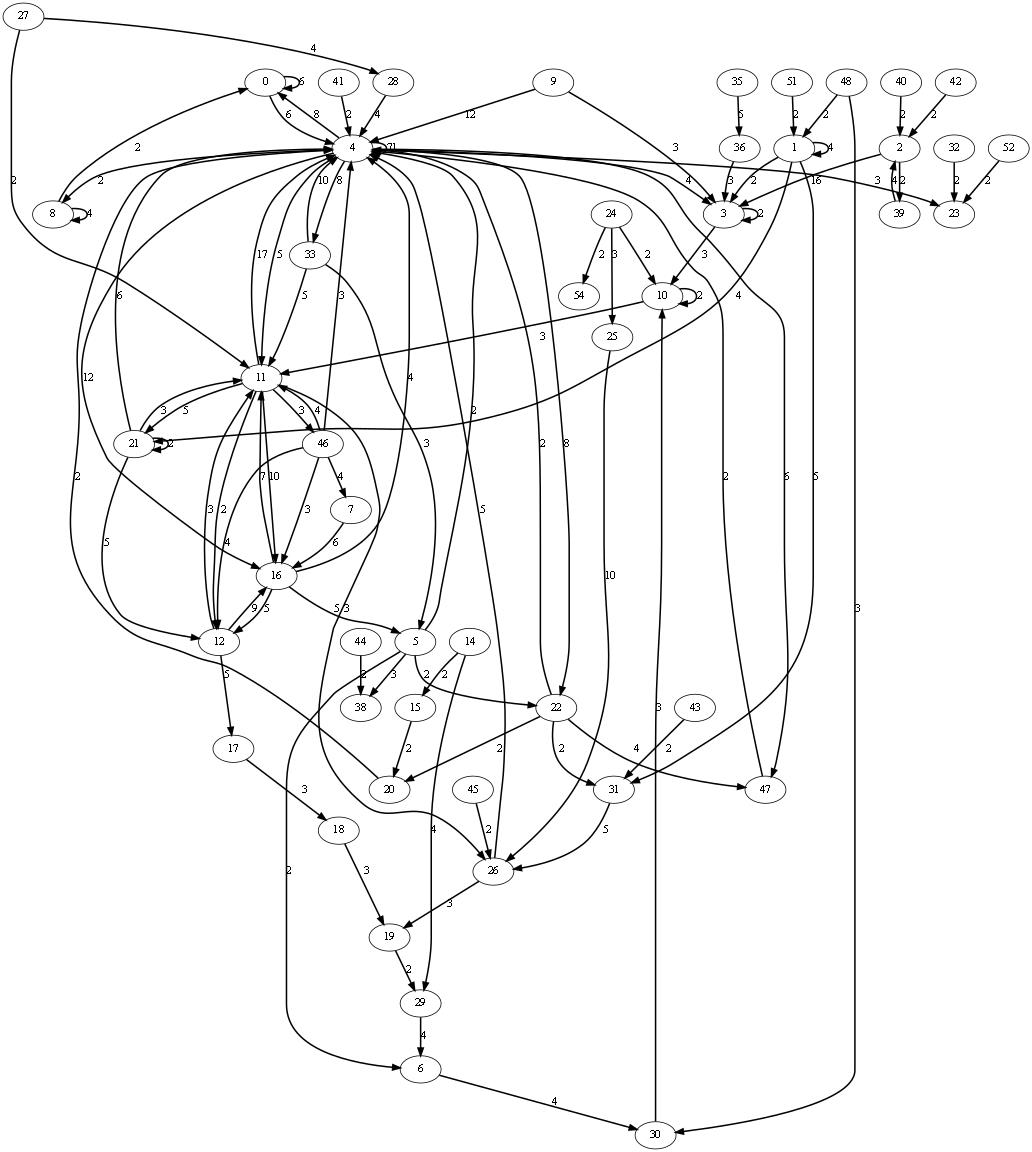

In [516]:
g = create_graph()
drawPDF(g, 'test')
drawImage(g)

#### Create compressed network from Table seq_of_events

In [517]:
initialIDs = set(occurrences['ev_id']).intersection(set(seq_of_events['ev_id']))
part120_IDs = set(sum(aircraft.values.tolist(), []))

ev_ID = list(initialIDs.intersection(part120_IDs))

In [518]:
eventCodes.head()

,code,meaning
0,100,ABRUPT MANEUVER
1,110,"ALTITUDE DEVIATION,UNCONTROLLED"
2,120,CARGO SHIFT
3,130,AIRFRAME/COMPONENT/SYSTEM FAILURE/MALFUNCTION
4,131,PROPELLER FAILURE/MALFUNCTION


In [519]:
df_seq_of_events = seq_of_events[seq_of_events['ev_id'].isin(ev_ID)].copy()

df_seq_of_events.drop(df_seq_of_events.index[6218], inplace = True)
df_seq_of_events.reset_index(inplace=True)
del df_seq_of_events['index']

In [520]:
df_seq_of_events.head()

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
0,20030314X00332,1,1,1,1,10403,C,1137,0.0,7/6/2004 15:23:06,JOHB
1,20001212X18554,1,1,1,2,24602,F,3130,4000.0,1/10/2001 10:43:11,dbo
2,20001212X18554,1,1,2,2,24608,C,3130,4111.0,1/10/2001 10:43:11,dbo
3,20001212X18554,1,1,3,4,90000,F,0,6110.0,1/10/2001 10:43:11,dbo
4,20001212X18554,1,1,4,2,24604,F,3134,4111.0,1/10/2001 10:43:11,dbo


In [521]:
df_seq_of_events.insert(6, 'Grouped_Subject_Code', None)
df_seq_of_events.insert(7, 'Simple_Subject_Code', None)

In [522]:
df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Subj_Code'].copy()
df_seq_of_events['Simple_Subject_Code'] = df_seq_of_events['Subj_Code'].copy()

def updateGroupSubjectCode(code):
    codeList = []
    
    if int(str(code)[:-2] + '00') in codeList:
        return code
    else:
        return int(str(code)[:-2] + '00')

df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Grouped_Subject_Code'].map(updateGroupSubjectCode)
df_seq_of_events['Simple_Subject_Code'] = df_seq_of_events['Subj_Code'].map(updateGroupSubjectCode)

In [523]:
df_seq_of_events.head()

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Grouped_Subject_Code,Simple_Subject_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
0,20030314X00332,1,1,1,1,10403,10400,10400,C,1137,0.0,7/6/2004 15:23:06,JOHB
1,20001212X18554,1,1,1,2,24602,24600,24600,F,3130,4000.0,1/10/2001 10:43:11,dbo
2,20001212X18554,1,1,2,2,24608,24600,24600,C,3130,4111.0,1/10/2001 10:43:11,dbo
3,20001212X18554,1,1,3,4,90000,90000,90000,F,0,6110.0,1/10/2001 10:43:11,dbo
4,20001212X18554,1,1,4,2,24604,24600,24600,F,3134,4111.0,1/10/2001 10:43:11,dbo


In [524]:
eventCodes[eventCodes['code'] == 31100]

,code,meaning


In [525]:
def findKeyByValue(val, highLevelGroup):
    for k, v in highLevelGroup.items():
        if val in v:
            return k
        
def mapToHigherLevel(code):
    
    highLevelGroup = {
        9910001: [10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 11300, 13000],
        9912001: [12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13100],
        9913001: [14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200,
                  15300, 15400, 15600, 15700, 15800, 15900, 16000, 16700, 16900],
        9914001: [17000, 17100, 17200, 17300],
        9915001: [18100, 18200, 18300, 18400, 18500, 19000, 19300],
        9916001: [21000, 21100],
        9918001: [19200, ],
        9919001: [20200],
        9920001: [20000],
        9930001: [20100],
        9940001: [22000, 22100, 22200, 22300, 22400, 22500, 22600, 22700, 22800, 22900, 23000, 23100, 23300],
        9950001: [24000, 24100, 24200, 24300, 24400, 24500, 24600, 24700, 25000],
        9960001: [30000, 30001, 31000, 31100, 31200, 32000, 33000, 33100, 34000, 
                  33200, 33400, 33500, 33600, 33700, 34100, 34200, 34300, 40000, 40001, 50001, 60000],
        9970001: [35000, 35100, 35200, 35300, 70100, 80100, 80200, 80300, 80400, 84100, 84200,
                  70000, 80000, 82000, 82100, 82200, 84000],
        9980001: [90000, 91000, 92000, 93000, 90100, 90200, 91100, 91200, 91300, 91400, 91500, 92200, 92300, 92400, 
                  93100, 93200, 93300]
    }
    
    
    allValues = sum(list(highLevelGroup.values()), [])
    
    if code in allValues:
        key = findKeyByValue(code, highLevelGroup)
        return key
    else:
        return code
    
df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Grouped_Subject_Code'].map(mapToHigherLevel)

In [526]:
df_seq_of_events.head(2)

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Grouped_Subject_Code,Simple_Subject_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
0,20030314X00332,1,1,1,1,10403,9910001,10400,C,1137,0.0,7/6/2004 15:23:06,JOHB
1,20001212X18554,1,1,1,2,24602,9950001,24600,F,3130,4000.0,1/10/2001 10:43:11,dbo


In [527]:
subjectCodes = sorted(list(df_seq_of_events['Grouped_Subject_Code'].unique()))

In [528]:
df_seq_of_events.head(3)

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Grouped_Subject_Code,Simple_Subject_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
0,20030314X00332,1,1,1,1,10403,9910001,10400,C,1137,0.0,7/6/2004 15:23:06,JOHB
1,20001212X18554,1,1,1,2,24602,9950001,24600,F,3130,4000.0,1/10/2001 10:43:11,dbo
2,20001212X18554,1,1,2,2,24608,9950001,24600,C,3130,4111.0,1/10/2001 10:43:11,dbo


In [529]:
def findEventSequence(ev_id):
    seqs = df_seq_of_events.loc[df_seq_of_events['ev_id'] == ev_id][['seq_event_no', 'Grouped_Subject_Code']]
    return seqs.drop_duplicates(subset = ['seq_event_no', 'Grouped_Subject_Code'])

def findEventOutcomes(ev_id):
    outcomes = occurrences.loc[occurrences['ev_id'] == ev_id][['Occurrence_No', 'Occurrence_Code']].copy()
    return outcomes.drop_duplicates(subset = ['Occurrence_No', 'Occurrence_Code'])


dictEventSequences = {}
for ID in ev_ID:
    
    seq = findEventSequence(ID)
    leafNodes = []

    if len(seq) > 0:
        for i in range(len(seq) - 1):
            if seq.iloc[i]['seq_event_no'] < seq.iloc[i+1]['seq_event_no']:
                codeFrom = seq.iloc[i]['Grouped_Subject_Code']
                codeTo = seq.iloc[i+1]['Grouped_Subject_Code']

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictEventSequences.keys():
                    dictEventSequences[key] += 1
                else:
                    dictEventSequences[key] = 1 
            else:
                leafNodes.append(seq.iloc[i]['Grouped_Subject_Code'])


        leafNodes.append(seq.iloc[-1]['Grouped_Subject_Code'])
        outcomes = findEventOutcomes(ID)

        ## connect leaft Nodes with event outcomes:
        for i in leafNodes:
            codeFrom = i
            codeTo = outcomes.iloc[0]['Occurrence_Code']

            key = str(codeFrom) + '->' + str(codeTo)
            if key in dictEventSequences.keys():
                dictEventSequences[key] += 1
            else:
                dictEventSequences[key] = 1

        outcomeLens = outcomes.shape[0]

        if outcomeLens > 1:
            for i in range(outcomeLens - 1):
                codeFrom = outcomes.iloc[i]['Occurrence_Code']
                codeTo = outcomes.iloc[i+1]['Occurrence_Code']

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictEventSequences.keys():
                    dictEventSequences[key] += 1
                else:
                    dictEventSequences[key] = 1

In [530]:
def createBN():
    occurrencesCodes = list(set(occurrences['Occurrence_Code']))
    
    g = """digraph top {
    \tsize ="12,12"; \n \t"""

    g_node_style = ''
    
    threshold = 10
    
    count = 0
    for key, value in dictEventSequences.items():
        
        #if count < 100:
        if '->' in key:
            nodeFrom = int(key.split('->')[0])
            nodeTo = int(key.split('->')[1])

            #if nodeFrom != nodeTo:
            #    print (nodeFrom, '-->', nodeTo)

            if nodeFrom in occurrencesCodes and value > threshold:
                g += str(nodeFrom) + '->' + str(nodeTo) + ' [label=' + str(value) + ']'
                g += '\n\t'

                g_node_style += str(nodeFrom) + """ [style=filled, color=".7 .4 1.0"]"""
                g_node_style += '\n\t'
            elif nodeTo in occurrencesCodes and value > threshold:
                g += str(nodeFrom) + '->' + str(nodeTo) + ' [label=' + str(value) + ']'
                g += '\n\t'

                g_node_style += str(nodeTo) + """ [style=filled, color=".7 .4 1.0"]"""
                g_node_style += '\n\t'
            elif value > threshold:
                g += str(nodeFrom) + '->' + str(nodeTo) + ' [style=bold, label=' + str(value) + ']'
                g += '\n\t'

            #count += 1
      
    g += g_node_style
    g = g[:-1]
    g += '}'
    
    return g

In [531]:
len(subjectCodes)

15

In [532]:
eventCodes[eventCodes['code'] == 10001]

,code,meaning
633,10001,"FUSELAGE,CREW COMPARTMENT"


In [533]:
subjectCodes

[9910001,
 9912001,
 9913001,
 9914001,
 9915001,
 9916001,
 9918001,
 9919001,
 9920001,
 9930001,
 9940001,
 9950001,
 9960001,
 9970001,
 9980001]

In [534]:
dictSubjectCodes = {}
for i in range(1, len(subjectCodes)+1):
    dictSubjectCodes[subjectCodes[i-1]] = i

In [535]:
dictEventSequences

{'9912001->430': 10,
 '9950001->430': 112,
 '9950001->9910001': 91,
 '9910001->130': 200,
 '130->190': 6,
 '9940001->9950001': 66,
 '9950001->200': 25,
 '9919001->9950001': 70,
 '9950001->310': 119,
 '9914001->9950001': 48,
 '9950001->100': 10,
 '9950001->9950001': 669,
 '9912001->100': 1,
 '9920001->9950001': 148,
 '9950001->9980001': 28,
 '9980001->9920001': 2,
 '9950001->9920001': 67,
 '9920001->9920001': 147,
 '9950001->9970001': 86,
 '9970001->9960001': 3,
 '9960001->9950001': 66,
 '9950001->9919001': 42,
 '9919001->9919001': 9,
 '9919001->240': 3,
 '240->230': 3,
 '230->310': 3,
 '9920001->9914001': 5,
 '9914001->9913001': 9,
 '9913001->9914001': 18,
 '9970001->9950001': 25,
 '9950001->9914001': 19,
 '9950001->9918001': 20,
 '9918001->9950001': 12,
 '9950001->354': 2,
 '354->351': 1,
 '351->180': 4,
 '180->230': 5,
 '230->430': 1,
 '9950001->9960001': 142,
 '9960001->9960001': 34,
 '9960001->430': 34,
 '9920001->110': 10,
 '9913001->9950001': 82,
 '9920001->130': 5,
 '130->171': 

In [536]:
eventCodes[eventCodes['code'] == 320]

,code,meaning
37,320,ON GROUND/WATER ENCOUNTER WITH TERRAIN/WATER


In [537]:
eventCodes.head()

,code,meaning
0,100,ABRUPT MANEUVER
1,110,"ALTITUDE DEVIATION,UNCONTROLLED"
2,120,CARGO SHIFT
3,130,AIRFRAME/COMPONENT/SYSTEM FAILURE/MALFUNCTION
4,131,PROPELLER FAILURE/MALFUNCTION


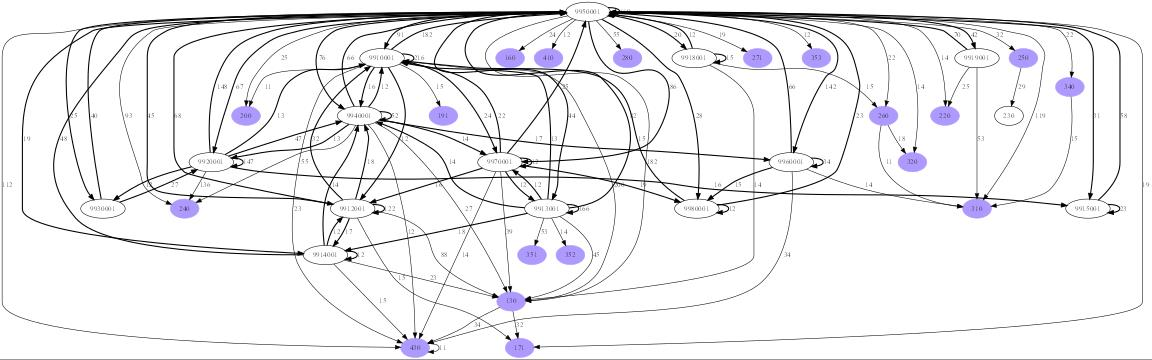

In [538]:
BN = createBN()
drawImage(BN)

In [539]:
drawPDF(BN, 'BN')

### Challenges:

#### 1. How to detect loop in the constructed graph
#### 2. How to break the loop
#### 3. Visualization --> too many nodes

In [540]:
df_seq_of_events.head()

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Grouped_Subject_Code,Simple_Subject_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
0,20030314X00332,1,1,1,1,10403,9910001,10400,C,1137,0.0,7/6/2004 15:23:06,JOHB
1,20001212X18554,1,1,1,2,24602,9950001,24600,F,3130,4000.0,1/10/2001 10:43:11,dbo
2,20001212X18554,1,1,2,2,24608,9950001,24600,C,3130,4111.0,1/10/2001 10:43:11,dbo
3,20001212X18554,1,1,3,4,90000,9980001,90000,F,0,6110.0,1/10/2001 10:43:11,dbo
4,20001212X18554,1,1,4,2,24604,9950001,24600,F,3134,4111.0,1/10/2001 10:43:11,dbo


In [541]:
def findEventSequenceSimpleCode(ev_id):
    seqs = df_seq_of_events.loc[df_seq_of_events['ev_id'] == ev_id][['seq_event_no', 'Simple_Subject_Code']]
    return seqs.drop_duplicates(subset = ['seq_event_no', 'Simple_Subject_Code'])

def findEventOutcomesSimpleCode(ev_id):
    outcomes = occurrences.loc[occurrences['ev_id'] == ev_id][['Occurrence_No', 'Occurrence_Code']].copy()
    return outcomes.drop_duplicates(subset = ['Occurrence_No', 'Occurrence_Code'])

In [542]:
dictBN = {}
nodeList = []

for ID in ev_ID:
    
    seq = findEventSequenceSimpleCode(ID)
    leafNodes = []

    if len(seq) > 0:
        for i in range(len(seq) - 1):
            if seq.iloc[i]['seq_event_no'] < seq.iloc[i+1]['seq_event_no']:
                codeFrom = seq.iloc[i]['Simple_Subject_Code']
                codeTo = seq.iloc[i+1]['Simple_Subject_Code']
                
                nodeList.append(codeFrom)
                nodeList.append(codeTo)

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictBN.keys():
                    dictBN[key] += 1
                else:
                    dictBN[key] = 1 
            else:
                leafNodes.append(seq.iloc[i]['Simple_Subject_Code'])

        leafNodes.append(seq.iloc[-1]['Simple_Subject_Code'])
        outcomes = findEventOutcomesSimpleCode(ID)

        ## connect leaft Nodes with event outcomes:
        for i in leafNodes:
            codeFrom = i
            codeTo = outcomes.iloc[0]['Occurrence_Code']
            
            nodeList.append(codeFrom)
            nodeList.append(codeTo)

            key = str(codeFrom) + '->' + str(codeTo)
            if key in dictBN.keys():
                dictBN[key] += 1
            else:
                dictBN[key] = 1

        outcomeLens = outcomes.shape[0]

        if outcomeLens > 1:
            for i in range(outcomeLens - 1):
                codeFrom = outcomes.iloc[i]['Occurrence_Code']
                codeTo = outcomes.iloc[i+1]['Occurrence_Code']
                
                nodeList.append(codeFrom)
                nodeList.append(codeTo)

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictBN.keys():
                    dictBN[key] += 1
                else:
                    dictBN[key] = 1

#### Construct transition matrix

In [574]:
#### Label each node with a sequential number
#### Detect loops in the network 
#### Find the direction of observed node --> consequence

import networkx as nx
G = nx.DiGraph()

count = len(set(nodeList)) 
nodeIDList = list(set(nodeList))
TP = np.zeros(shape = (count, count))
    
## add node
for i in range(1, count):
    G.add_node(i)

## add edges
for i in dictBN:
    nodeFrom, nodeTo = int(i.split('->')[0]), int(i.split('->')[1])
    #print (nodeFrom, nodeTo)
    #if nodeFrom != nodeTo:
        #print (str(nodeFrom) + '->' + str(nodeTo))
        #print (dictBN[str(nodeFrom) + '->' + str(nodeTo)])
    G.add_edge(nodeFrom, nodeTo)
        
    if nodeTo == 290:
        #pass
        print (str(nodeFrom) + '->' + str(nodeTo), dictBN[i])
        
    TP[nodeIDList.index(nodeFrom), nodeIDList.index(nodeTo)] = dictBN[i]
    
    #print (nodeIDList.index(nodeFrom), nodeIDList.index(nodeTo), dictBN[i])
    
    if nodeIDList.index(nodeFrom) == 1:
        pass
        #print (nodeIDList.index(nodeFrom))

130->290 1
192->290 1
196->290 1


In [575]:
TP

array([[6., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 6., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 5., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [576]:
for i in range(TP.shape[0]):
    if sum(TP[i, :]) == 0:
        TP[i, i] = 1

In [577]:
TP[109, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [578]:
row_sums = TP.sum(axis=1)
TP = TP / row_sums[:, np.newaxis]

In [579]:
nodeIDs = set(nodeList)

for id in nodeIDs:
    try:
        res = nx.find_cycle(G, source = id, orientation='original')
        if id == res[0][0]:
            print (res)
    except:
        pass

[(12300, 12300, 'forward')]
[(15400, 15400, 'forward')]
[(19000, 19000, 'forward')]
[(17000, 15100, 'forward'), (15100, 17000, 'forward')]
[(140, 140, 'forward')]
[(14500, 14500, 'forward')]
[(192, 192, 'forward')]
[(12500, 12500, 'forward')]
[(15100, 17000, 'forward'), (17000, 15100, 'forward')]
[(10500, 17200, 'forward'), (17200, 10500, 'forward')]
[(17200, 10500, 'forward'), (10500, 17200, 'forward')]
[(12100, 12100, 'forward')]
[(33100, 33100, 'forward')]
[(10100, 10100, 'forward')]
[(12700, 12700, 'forward')]
[(33200, 33200, 'forward')]


### Forward propagation

In [580]:
set(df_seq_of_events['Simple_Subject_Code'])

{10000,
 10100,
 10200,
 10300,
 10400,
 10500,
 10600,
 10700,
 10800,
 11300,
 12000,
 12100,
 12200,
 12300,
 12400,
 12500,
 12600,
 12700,
 12800,
 12900,
 13000,
 13100,
 14000,
 14100,
 14200,
 14300,
 14400,
 14500,
 14600,
 14700,
 14800,
 14900,
 15000,
 15100,
 15200,
 15300,
 15400,
 15600,
 15700,
 15800,
 15900,
 16000,
 16700,
 16900,
 17000,
 17100,
 17200,
 17300,
 18100,
 18200,
 18300,
 18400,
 18500,
 19000,
 19200,
 19300,
 20000,
 20100,
 20200,
 21000,
 21100,
 22000,
 22100,
 22200,
 22300,
 22400,
 22500,
 22600,
 22700,
 22800,
 22900,
 23000,
 23100,
 23300,
 24000,
 24100,
 24200,
 24300,
 24400,
 24500,
 24600,
 24700,
 25000,
 30000,
 31100,
 31200,
 32000,
 33000,
 33100,
 33200,
 33400,
 33500,
 33600,
 33700,
 34000,
 34100,
 34200,
 34300,
 35000,
 35100,
 35200,
 35300,
 40000,
 60000,
 70000,
 70100,
 80000,
 80100,
 80200,
 80300,
 80400,
 82000,
 82100,
 82200,
 84000,
 84100,
 84200,
 90000,
 90100,
 90200,
 91000,
 91100,
 91200,
 91300,
 91400,


In [581]:
eventCodes[eventCodes['code']== 17200]

,code,meaning
1516,17200,LIGHT(S)


In [582]:
N = TP.shape[0]
initialState = np.zeros(shape = (N, 1)).flatten()

startNodeID = nodeIDList.index(17200)
initialState[startNodeID] = 1

In [583]:
startNode = [17200]

In [584]:
dictForwardGraph = {}

for i in range(1000):
    initialState = np.dot(TP.transpose(), initialState)
    
    #print (nodeIDList[np.argmax(initialState)])
    print (initialState[[41, 66, 69, 109]])
    
    for s in startNode:
        # calculate the sum of all counts
        count = 0
        for key, val in dictBN.items():
            if str(s) + '->' in key:
                count = count + val

        startNode = []
        for key, val in dictBN.items():
            if str(s) + '->' in key and val/count > 0.05:
                t = key.split('->')[1]
                
                startNode.append(t)
                
                dictForwardGraph[str(s) + '->' + str(t)] = val/count

[0.0625 0.     0.     0.    ]
[0.12613242 0.00566107 0.00343249 0.0003453 ]
[0.10858469 0.0274765  0.00713329 0.00407336]
[0.10375885 0.04515548 0.00665681 0.01620987]
[0.10039952 0.06438664 0.00685237 0.03405389]
[0.09877059 0.078278   0.00663707 0.05835492]
[0.09685038 0.08811258 0.00645592 0.08720564]
[0.09449966 0.09252396 0.00628349 0.11926356]
[0.09113574 0.09288357 0.00606382 0.15272147]
[0.08699583 0.09057034 0.00580722 0.18620745]
[0.08241755 0.08680005 0.00551927 0.21881394]
[0.07768887 0.08235673 0.00521854 0.25004239]
[0.07300793 0.07769798 0.00491453 0.27966337]
[0.06848304 0.07306751 0.00461685 0.30760423]
[0.0641699  0.06858297 0.0043301  0.33387738]
[0.06008906 0.06429837 0.00405719 0.35853627]
[0.0562447  0.06023487 0.00379904 0.38165344]
[0.0526319  0.05639837 0.00355589 0.40330882]
[0.04924198 0.05278671 0.0033274  0.42358436]
[0.04606442 0.04939361 0.00311303 0.44256112]
[0.04308801 0.04621036 0.0029121  0.46031783]
[0.04030141 0.043227   0.00272391 0.47693003]
[0.0

[7.61296399e-06 8.16759364e-06 5.14604395e-07 7.16813833e-01]
[7.11968768e-06 7.63838052e-06 4.81260989e-07 7.16816769e-01]
[6.65837285e-06 7.14345738e-06 4.50078043e-07 7.16819515e-01]
[6.22694857e-06 6.68060240e-06 4.20915574e-07 7.16822083e-01]
[5.82347810e-06 6.24773777e-06 3.93642664e-07 7.16824485e-01]
[5.44615019e-06 5.84292028e-06 3.68136882e-07 7.16826731e-01]
[5.09327097e-06 5.46433264e-06 3.44283729e-07 7.16828831e-01]
[4.76325629e-06 5.11027529e-06 3.21976122e-07 7.16830795e-01]
[4.45462467e-06 4.77915883e-06 3.01113921e-07 7.16832633e-01]
[4.16599060e-06 4.46949681e-06 2.81603469e-07 7.16834351e-01]
[3.89605835e-06 4.17989911e-06 2.63357184e-07 7.16835957e-01]
[3.64361617e-06 3.90906568e-06 2.46293152e-07 7.16837460e-01]
[3.40753079e-06 3.65578070e-06 2.30334772e-07 7.16838865e-01]
[3.18674238e-06 3.41890712e-06 2.15410403e-07 7.16840179e-01]
[2.98025980e-06 3.19738160e-06 2.01453047e-07 7.16841408e-01]
[2.78715609e-06 2.99020965e-06 1.88400047e-07 7.16842558e-01]
[2.60656

[9.61865298e-10 1.03194037e-09 6.50180548e-11 7.16859142e-01]
[8.99541956e-10 9.65076568e-10 6.08052587e-11 7.16859142e-01]
[8.41256808e-10 9.02545154e-10 5.68654274e-11 7.16859143e-01]
[7.86748203e-10 8.44065417e-10 5.31808746e-11 7.16859143e-01]
[7.35771443e-10 7.89374830e-10 4.97350597e-11 7.16859143e-01]
[6.88097683e-10 7.38227879e-10 4.65125137e-11 7.16859144e-01]
[6.43512909e-10 6.90394956e-10 4.34987702e-11 7.16859144e-01]
[6.01816972e-10 6.45661332e-10 4.06803000e-11 7.16859144e-01]
[5.62822691e-10 6.03826189e-10 3.80444504e-11 7.16859144e-01]
[5.26355017e-10 5.64701723e-10 3.55793887e-11 7.16859145e-01]
[4.92250237e-10 5.28112298e-10 3.32740489e-11 7.16859145e-01]
[4.60355252e-10 4.93893657e-10 3.11180818e-11 7.16859145e-01]
[4.30526878e-10 4.61892187e-10 2.91018090e-11 7.16859145e-01]
[4.02631211e-10 4.31964229e-10 2.72161791e-11 7.16859145e-01]
[3.76543023e-10 4.03975430e-10 2.54527271e-11 7.16859146e-01]
[3.52145200e-10 3.77800145e-10 2.38035367e-11 7.16859146e-01]
[3.29328

[7.60369892e-14 8.15765358e-14 5.13978116e-15 7.16859148e-01]
[7.11102294e-14 7.62908452e-14 4.80675289e-15 7.16859148e-01]
[6.65026953e-14 7.13476370e-14 4.49530293e-15 7.16859148e-01]
[6.21937030e-14 6.67247203e-14 4.20403314e-15 7.16859148e-01]
[5.81639086e-14 6.24013420e-14 3.93163596e-15 7.16859148e-01]
[5.43952217e-14 5.83580938e-14 3.67688856e-15 7.16859148e-01]
[5.08707240e-14 5.45768248e-14 3.43864731e-15 7.16859148e-01]
[4.75745935e-14 5.10405603e-14 3.21584274e-15 7.16859148e-01]
[4.44920334e-14 4.77334254e-14 3.00747461e-15 7.16859148e-01]
[4.16092054e-14 4.46405738e-14 2.81260755e-15 7.16859148e-01]
[3.89131681e-14 4.17481213e-14 2.63036675e-15 7.16859148e-01]
[3.63918185e-14 3.90430830e-14 2.45993410e-15 7.16859148e-01]
[3.40338378e-14 3.65133157e-14 2.30054452e-15 7.16859148e-01]
[3.18286408e-14 3.41474627e-14 2.15148246e-15 7.16859148e-01]
[2.97663278e-14 3.19349035e-14 2.01207876e-15 7.16859148e-01]
[2.78376409e-14 2.98657053e-14 1.88170762e-15 7.16859148e-01]
[2.60339

[7.34876000e-18 7.88414152e-18 4.96745315e-19 7.16859148e-01]
[6.87260260e-18 7.37329447e-18 4.64559075e-19 7.16859148e-01]
[6.42729746e-18 6.89554737e-18 4.34458317e-19 7.16859148e-01]
[6.01084553e-18 6.44875554e-18 4.06307916e-19 7.16859148e-01]
[5.62137730e-18 6.03091326e-18 3.79981499e-19 7.16859148e-01]
[5.25714436e-18 5.64014475e-18 3.55360882e-19 7.16859148e-01]
[4.91651163e-18 5.27469579e-18 3.32335540e-19 7.16859148e-01]
[4.59794994e-18 4.93292583e-18 3.10802107e-19 7.16859148e-01]
[4.30002922e-18 4.61330059e-18 2.90663917e-19 7.16859148e-01]
[4.02141204e-18 4.31438523e-18 2.71830566e-19 7.16859148e-01]
[3.76084766e-18 4.03483787e-18 2.54217508e-19 7.16859148e-01]
[3.51716635e-18 3.77340357e-18 2.37745675e-19 7.16859148e-01]
[3.28927419e-18 3.52890871e-18 2.22341122e-19 7.16859148e-01]
[3.07614813e-18 3.30025572e-18 2.07934696e-19 7.16859148e-01]
[2.87683142e-18 3.08641812e-18 1.94461723e-19 7.16859148e-01]
[2.69042928e-18 2.88643597e-18 1.81861721e-19 7.16859148e-01]
[2.51610

[6.21180125e-22 6.66435156e-22 4.19891679e-23 7.16859148e-01]
[5.80931224e-22 6.23253989e-22 3.92685112e-23 7.16859148e-01]
[5.43290220e-22 5.82870713e-22 3.67241374e-23 7.16859148e-01]
[5.08088137e-22 5.45104042e-22 3.43446244e-23 7.16859148e-01]
[4.75166947e-22 5.09784433e-22 3.21192902e-23 7.16859148e-01]
[4.44378860e-22 4.76753333e-22 3.00381448e-23 7.16859148e-01]
[4.15585665e-22 4.45862457e-22 2.80918457e-23 7.16859148e-01]
[3.88658103e-22 4.16973133e-22 2.62716556e-23 7.16859148e-01]
[3.63475292e-22 3.89955671e-22 2.45694034e-23 7.16859148e-01]
[3.39924183e-22 3.64688786e-22 2.29774473e-23 7.16859148e-01]
[3.17899050e-22 3.41059049e-22 2.14886408e-23 7.16859148e-01]
[2.97301019e-22 3.18960383e-22 2.00963004e-23 7.16859148e-01]
[2.78037622e-22 2.98293584e-22 1.87941756e-23 7.16859148e-01]
[2.60022382e-22 2.78965874e-22 1.75764211e-23 7.16859148e-01]
[2.43174427e-22 2.60890489e-22 1.64375701e-23 7.16859148e-01]
[2.27418122e-22 2.43986286e-22 1.53725100e-23 7.16859148e-01]
[2.12682

[7.84834405e-26 8.42012192e-26 5.30515099e-27 7.16859148e-01]
[7.33981647e-26 7.87454642e-26 4.96140771e-27 7.16859148e-01]
[6.86423856e-26 7.36432108e-26 4.63993701e-27 7.16859148e-01]
[6.41947536e-26 6.88715541e-26 4.33929576e-27 7.16859148e-01]
[6.00353026e-26 6.44090733e-26 4.05813434e-27 7.16859148e-01]
[5.61453602e-26 6.02357357e-26 3.79519057e-27 7.16859148e-01]
[5.25074636e-26 5.63328063e-26 3.54928404e-27 7.16859148e-01]
[4.91052818e-26 5.26827643e-26 3.31931083e-27 7.16859148e-01]
[4.59235418e-26 4.92692240e-26 3.10423857e-27 7.16859148e-01]
[4.29479603e-26 4.60768615e-26 2.90310176e-27 7.16859148e-01]
[4.01651794e-26 4.30913458e-26 2.71499745e-27 7.16859148e-01]
[3.75627067e-26 4.02992743e-26 2.53908123e-27 7.16859148e-01]
[3.51288592e-26 3.76881130e-26 2.37456336e-27 7.16859148e-01]
[3.28527111e-26 3.52461399e-26 2.22070531e-27 7.16859148e-01]
[3.07240443e-26 3.29623927e-26 2.07681637e-27 7.16859148e-01]
[2.87333028e-26 3.08266191e-26 1.94225061e-27 7.16859148e-01]
[2.68715

[8.67267056e-30 9.30450335e-30 5.86236110e-31 7.16859148e-01]
[8.11073137e-30 8.70162502e-30 5.48251380e-31 7.16859148e-01]
[7.58520260e-30 8.13780974e-30 5.12727842e-31 7.16859148e-01]
[7.09372508e-30 7.61052645e-30 4.79506026e-31 7.16859148e-01]
[6.63409247e-30 7.11740809e-30 4.48436792e-31 7.16859148e-01]
[6.20424142e-30 6.65624096e-30 4.19380666e-31 7.16859148e-01]
[5.80224224e-30 6.22495481e-30 3.92207209e-31 7.16859148e-01]
[5.42629030e-30 5.82161353e-30 3.66794437e-31 7.16859148e-01]
[5.07469788e-30 5.44440644e-30 3.43028266e-31 7.16859148e-01]
[4.74588663e-30 5.09164020e-30 3.20802006e-31 7.16859148e-01]
[4.43838046e-30 4.76173118e-30 3.00015880e-31 7.16859148e-01]
[4.15079892e-30 4.45319838e-30 2.80576576e-31 7.16859148e-01]
[3.88185101e-30 4.16465672e-30 2.62396827e-31 7.16859148e-01]
[3.63032938e-30 3.89481091e-30 2.45395021e-31 7.16859148e-01]
[3.39510491e-30 3.64244955e-30 2.29494834e-31 7.16859148e-01]
[3.17512163e-30 3.40643976e-30 2.14624888e-31 7.16859148e-01]
[2.96939

In [585]:
nodeIDList.index(290)

109

In [586]:
initialState[109]

0.7168591477772656

In [587]:
TP.transpose()[109, np.where(TP.transpose()[109, :]>0)]

array([[0.00552486, 0.33333333, 0.33333333, 1.        ]])

In [588]:
np.dot(TP.transpose()[109, :], initialState)

0.7168591477772656

In [589]:
initialState[[41, 66, 69, 109]]

array([1.42117114e-30, 1.52470817e-30, 9.60652010e-32, 7.16859148e-01])

In [590]:
np.where(TP.transpose()[109, :]>0)

(array([ 41,  66,  69, 109], dtype=int64),)

In [591]:
TP.transpose()[109, np.where(TP.transpose()[109, :]>0)]

array([[0.00552486, 0.33333333, 0.33333333, 1.        ]])

In [592]:
initialState[109]

0.7168591477772656

In [593]:
print (np.where(states[:, 109] > 0))
states[np.where(states[:, 109] > 0), 109]

(array([], dtype=int64),)


array([], shape=(1, 0), dtype=float64)

In [594]:
probPerState[161]

0.0

In [595]:
np.where(states[:, 109] > 0.0001)

(array([], dtype=int64),)

In [596]:
def createFowardPropagation(FPN):
    
    g = """digraph top {
    \tsize ="12,12"; \n \t"""

    g_node_style = ''
    
    for key, value in FPN.items():

        if '->' in key:
            nodeFrom = int(key.split('->')[0])
            nodeTo = int(key.split('->')[1])
            g += str(nodeFrom) + '->' + str(nodeTo) + ' [label=' + str(round(value, 2)) + ']'
            g += '\n\t'
      
    g += g_node_style
    g = g[:-1]
    g += '}'
    
    return g

In [597]:
FPN = createFowardPropagation(dictForwardGraph)
drawImage(FPN)
drawPDF(FPN, 'FPN')

In [598]:
nodeIDList.index(290)

109

In [599]:
np.where(states[:, 109] > 0.01)

(array([], dtype=int64),)

In [600]:
dictForwardGraph

{'17200->10500': 0.125,
 '17200->24100': 0.125,
 '17200->24600': 0.125,
 '17200->23000': 0.0625,
 '17200->24500': 0.125,
 '17200->23300': 0.0625,
 '17200->340': 0.0625,
 '17200->130': 0.0625,
 '17200->82100': 0.0625,
 '17200->12000': 0.0625,
 '17200->171': 0.0625,
 '17200->17200': 0.0625,
 '10500->430': 0.15384615384615385,
 '10500->10500': 0.15384615384615385,
 '10500->24100': 0.18461538461538463,
 '10500->130': 0.15384615384615385,
 '10500->24000': 0.13846153846153847,
 '24100->10400': 0.08080808080808081,
 '24100->24100': 0.06734006734006734,
 '24100->130': 0.23232323232323232,
 '24600->24600': 0.24622030237580994,
 '24600->280': 0.0755939524838013,
 '24600->24000': 0.08639308855291576,
 '24600->240': 0.05399568034557235,
 '24600->310': 0.06479481641468683,
 '23000->31100': 0.09090909090909091,
 '23000->130': 0.36363636363636365,
 '23000->100': 0.09090909090909091,
 '23000->430': 0.09090909090909091,
 '23000->20200': 0.09090909090909091,
 '23000->24100': 0.09090909090909091,
 '23000

In [601]:
eventIndices = np.where(initialState > 0.001)

dictOutcome = {}

for i in list(eventIndices[0]):
    code = nodeIDList[i]
    meaning = eventCodes[eventCodes['code']== code]['meaning']
    p = initialState[i]
    
    dictOutcome[code] = p

Text(0, 0.5, 'Probability')

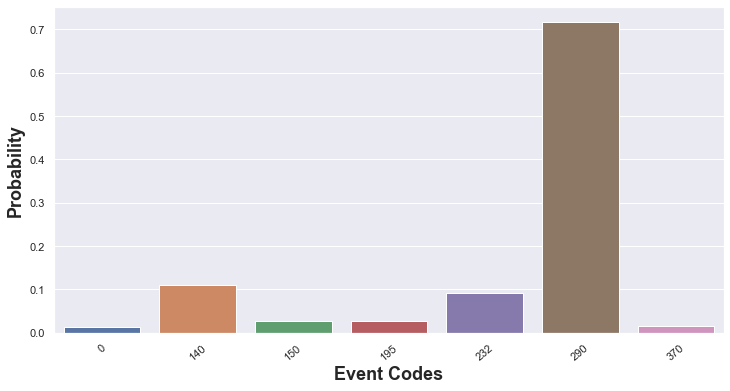

In [602]:
plt.figure(figsize = (12, 6))

sns.barplot(x = list(dictOutcome.keys()), y = list(dictOutcome.values()))
sns.set(font_scale=1)
plt.xticks(rotation=40)

plt.xlabel('Event Codes', fontsize = 18, fontweight = 'bold')
plt.ylabel('Probability', fontsize = 18, fontweight = 'bold')

In [603]:
eventCodes[eventCodes['code']== 140]

,code,meaning
6,140,DECOMPRESSION
